This file is to try SBI_SGM 

And I train model with a general connectome.


# import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from tqdm import trange, tqdm

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import logging

In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [24]:
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from sbi_sgm import SBI_SGM
from spectrome import Brain
from sgm.sgm import SGM
from utils.standardize import psd_2tr, stdz_vec

# Load real data PSD and brain

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

In [6]:
# define a SGM model
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS);

# SBI-SGM class

In [7]:
logger = logging.getLogger("sbi_sgm")
#logger.handlers[0].setLevel(logging.INFO)
# if you feel the output info is annoying, uncomment this
#logger.handlers[0].setLevel(logging.WARNING)

<Logger sbi_sgm (DEBUG)>

In [12]:
# initial the SBI_SGM class
# sgmmodel: SGM class.
# save_folder: the folder you want to save the results to, str or bool, if True, it generates a default folder
# other params for fitting sbi, refer to source file
sbi_sgm = SBI_SGM(sgmmodel, save_folder="test", num_prior_sps=1000);

2023-12-04 22:13:33,116 - sbi_sgm - INFO - In this class, the sgm parameter order is ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei'].
2023-12-04 22:13:33,118 - sbi_sgm - INFO - {'noise_sd': 0.2, 'num_prior_sps': 1000, 'den_est': 'nsf', 'is_embed': False, 'prior_sd': 10, 'k': 0.1, 'names': ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei'], 'prior_bds': array([[5.e-03, 3.e-02],
       [5.e-03, 2.e-01],
       [5.e-03, 3.e-02],
       [5.e+00, 2.e+01],
       [1.e-01, 1.e+00],
       [1.e-03, 2.e+00],
       [1.e-03, 7.e-01]])}
2023-12-04 22:13:33,120 - sbi_sgm - INFO - Results will be saved at /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/mypkg/../results/test.


In [13]:
# now you can fit the model
# load: if you have saved results, you can set load = true to load it
sbi_sgm.SBI_fit(load=False)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM_clean/mypkg/../results/test/posterior.pkl


In [16]:
# you add the psd data for inference 
# note that psd is not in dB, it is in linear (abs magnitude)
sbi_sgm.add_data(psd=ind_psd[:, :, 0])

In [18]:
# Get the posterior samples of SGM
# n: num of sps to draw
sbi_sgm.get_post_sps(n=1000);

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# based on generated sgm parameters, get modeled psd and sp
# Now psd is in std dB
psd, sp = sbi_sgm.get_model_psd_sp();

In [21]:
# you can further get posterior PSD (in std dB)
# n: num of sps to draw
sbi_sgm.get_post_psd_sps();

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

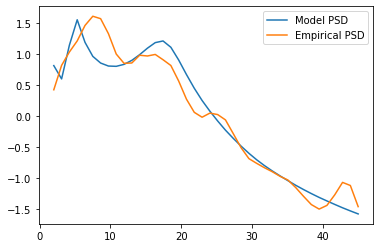

In [28]:
plt.plot(FREQS, stdz_vec(psd.mean(axis=0)), label="Model PSD")
plt.plot(FREQS, stdz_vec(psd_2tr(ind_psd[:, :, 0]).mean(axis=0)), label="Empirical PSD")
plt.legend()